In [2]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib import animation
import numba

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

The True Wave Equation taking into account Damping and Stress-Strain Coupling, is given by $$\frac{\partial^2 y}{\partial x^2}-\frac{1}{c^2}\frac{\partial^2 y}{\partial t^2}-\gamma \frac{\partial y}{\partial t}-l^2\frac{\partial^4 y}{\partial x^4}=0$$

1. Parameters: 
    - $y:$ Amplitude of string
    - $x:$ Position of the string
    - $c:$ Speed of wave [m/sec]
    - $\gamma:$ Damping Constant [sec/m]
    - $l:$ Characteristic Length representing the Stiffness term [Dimensionless]
<br></br>
2. Boundary conditions: 
    - $y(0,t)=y(L,t)=0$ ($L:$ length of string)
    - $y(x,0)=f(x)$

In Discrete form: $$y_j^{m+1}=\bigg[\frac{1}{c^2 \delta t^2}+\frac{\gamma}{2 \delta t}\bigg]^{-1} \bigg[\frac{1}{\delta x^2}\bigg(y_{j+1}^m+y_{j-1}^m-2y_j^m \bigg)-\frac{1}{c^2 \delta t^2}\bigg(y_j^{m-1}-2y_j^m \bigg)+\frac{\gamma}{2\delta t}y_j^{m-1}-\frac{l^2}{\delta x^4}\bigg(y_{j-2}^m-4y_{j-1}^m+6y_j^m-4y_{j+1}^m+y_{j+2}^m \bigg) \bigg]$$  where
- $j$ is the Position Index.
- $m$ is the Time Index.
- These two form a grid of points which, at time $m+1$ depend only on those at time $m$.

For this to be stable, it is required that $\displaystyle c\frac{\delta t}{\delta x}<1$.
- $L=0.7$
- $N_x=101$ guitar string positions and thus $\delta x=0.7$ mm
- To obtain a suitable constraint for a frequency $f=220$ Hz, set $\delta t=5e-06$ sec and $N_t=500000$
- $l=2e-06$ m and $\gamma=2.6e-05$ sec/m

In [3]:
Nx = 101
Nt = 500000

L = 0.7
l = 2e-06
f = 220
gamma = 2.6e-05

c = 2 * L * f
dx = L / (Nx - 1)
dt = 5e-06

In [4]:
ya = np.linspace(0, 0.01, 70)
yb = np.linspace(0.01, 0, 31)

y0 = np.concatenate([ya, yb])

In [5]:
sol = np.zeros([Nt, Nx])

sol[0] = y0
sol[1] = y0

In [6]:
@numba.jit('f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)', nopython = True, nogil = True)
def compute_d(d, times, length, dt, dx, l, gamma):
    length = len(d[0])
    for t in range(1, times - 1):
        for j in range(2, length - 2):
            outer_fact = (1 / (c ** 2 * dt ** 2) + gamma / (2 * dt)) ** (-1)
            
            p1 = 1 / dx ** 2 * (d[t][j - 1] + d[t][j + 1] - 2 * d[t][j])
            p2 = 1 / (c ** 2 * dt ** 2) * (d[t - 1][j] - 2 * d[t][j])
            p3 = gamma / (2 * dt) * d[t - 1][j]
            p4 = l ** 2 / dx ** 4 * (d[t][j + 2] - 4 * d[t][j + 1] + 6 * d[t][j] - 4 * d[t][j - 1] + d[t][j - 2])

            d[t + 1][j] = outer_fact * (p1 - p2 + p3 - p4)
    return d

In [7]:
sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)
sol

array([[0.00000000e+00, 1.44927536e-04, 2.89855072e-04, ...,
        6.66666667e-04, 3.33333333e-04, 0.00000000e+00],
       [0.00000000e+00, 1.44927536e-04, 2.89855072e-04, ...,
        6.66666667e-04, 3.33333333e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.89855072e-04, ...,
        6.66666667e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.50403650e-06, ...,
        7.17436781e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.46398640e-07, ...,
        6.28238420e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.16235795e-07, ...,
        5.41751455e-06, 0.00000000e+00, 0.00000000e+00]])

Animation of String:

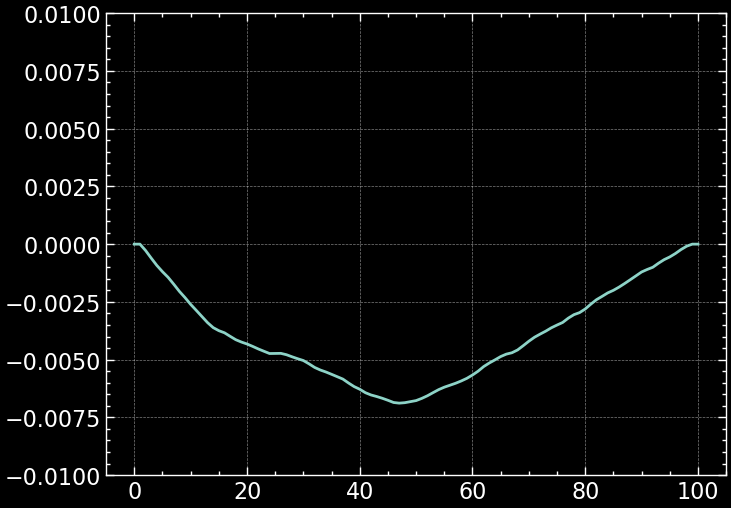

In [8]:
def animate(i):
    ax.clear()
    ax.plot(sol[i * 10])
    ax.set_ylim(-0.01, 0.01)

fig, ax = plt.subplots(1, 1)

ax.set_title('Motion of guitar string')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

ax.set_ylim(-0.01, 0.01)

ani = animation.FuncAnimation(fig, animate, frames = 500, interval = 50)
ani.save('..\Outputs\string.gif', writer = 'pillow', fps = 20)

Amount of 'harmonics' at any time $t$ (For creating a .wav file): $$A \propto \int_0^L y(x,t)\sin \bigg(\frac{n\pi x}L \bigg) \,dx$$ where $A$ represents the Amplitude of a harmonic $n$ at time $t$.

In [20]:
def integral(n):
    sin_arr = np.sin(n * np.pi * np.linspace(0, 1, 101))
    return np.array([sum(sin_arr * s) for s in sol])

In [21]:
hms = [integral(n) for n in range(10)]

In [22]:
tot = sum(hms)[::10]
tot = tot.astype(np.float32)

In [25]:
from scipy.io import wavfile
from IPython.display import Audio

wavfile.write('sound.wav', 20000, tot)
Audio('sound.wav')